In [1]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def process_docs(directory, is_trian):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc)
        # add to list
        documents.append(tokens)
    return documents

In [5]:
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
negative_docs = process_docs('data/negative', True)
positive_docs = process_docs('data/positive', True)
trainX = negative_docs + positive_docs
trainy = [0 for _ in range(900)] + [1 for _ in range(900)]
save_dataset([trainX,trainy], 'train.pkl')
 
# load all test reviews
negative_docs = process_docs('data/negative', False)
positive_docs = process_docs('data/positive', False)
testX = negative_docs + positive_docs
testY = [0 for _ in range(100)] + [1 for _ in range(100)]
save_dataset([testX,testY], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


In [7]:
def load_dataset(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [8]:
def max_length(lines):
    return max([len(s.split()) for s in lines])
 
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [9]:
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [10]:
# load training dataset
trainLines, trainLabels = load_dataset('train.pkl')
testLines, testLabels = load_dataset('test.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)


# define model
model = define_model(length, vocab_size)
# fit model
history = model.fit([trainX,trainX,trainX], array(trainLabels), validation_data=([testX, testX, testX], array(testLabels)), epochs=10, batch_size=16, verbose=1)
# save the model
model.save('model.h5')

Max document length: 1380
Vocabulary size: 44277
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1380, 100)    4427700     ['input_1[0][0]']                
                                             

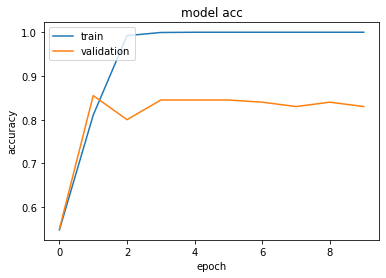

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

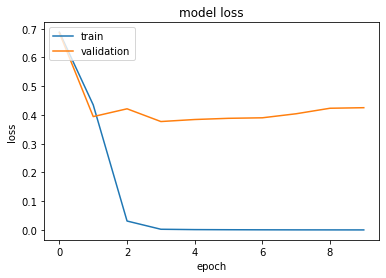

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()